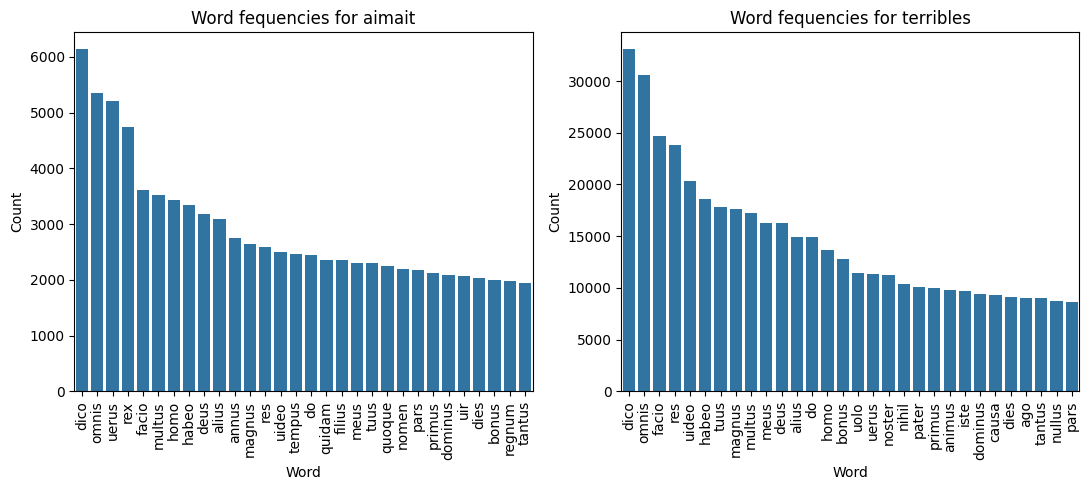

In [1]:
# applying some models to corpus. source used: https://medium.com/@kaushikpandav16/message-email-spam-detection-using-machine-learning-807b727533d5

from collections import Counter
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pylab

data = []
ctr = [Counter([]), Counter([])]
base_dir = 'corpus_preprocessed'

for target in ['aimait', 'terribles']:
    target_label = 1 if target == 'aimait' else 0
    
    target_dir = os.path.join(base_dir, target)
    
    for author in os.listdir(target_dir):
        author_dir = os.path.join(target_dir, author)
        
        if os.path.isdir(author_dir):
            for filename in os.listdir(author_dir):
                if filename.endswith('.txt'):
                    file_path = os.path.join(author_dir, filename)
                    
                    with open(file_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                    ctr[target_label] += Counter(text.split())
                    data.append({
                        'target': target_label,
                        'author': author,
                        'title': filename[:-4],
                        'text': text
                    })

df = pd.DataFrame(data)
plt.figure(figsize=(11, 5)) 
for i in (1,0):
    pylab.subplot(1, 2, 1 + int(not i))
    sns.barplot(data=pd.DataFrame(ctr[i].most_common(30), columns = ['Word', 'Count']), x='Word', y='Count')
    plt.xticks(rotation='vertical')
    plt.title('Word fequencies for ' + ('aimait' if i else 'terribles'))
plt.tight_layout() 
plt.show()

In [2]:
df

,target,author,title,text
0,1,prudentius,prud.psycho,praefatio senex fidelis primus credo uia abram...
1,1,sidonius,sidonius3,epistula sidonius auitus salus multus uinculum...
2,1,sidonius,sidonius2,epistula sidonius ecdicio salus duo nunc parit...
3,1,sidonius,sidonius1,epistula sidonius constantio salus praecipio d...
4,1,sidonius,sidonius5,epistula sidonius petronius salus audio lectit...
...,...,...,...,...
880,0,tacitus,tac.ann15,interea rex parthi uologaeses cognosco corbulo...
881,0,tacitus,tac.ann11,ualerium asiaticum bis consul quondam adulter ...
882,0,tacitus,tac.ann12,caedes messalinae convulsus princeps domus ori...
883,0,tacitus,tac.ann13,primus nouus principatus mors iunii silanus pr...


In [24]:
df.target.value_counts()

target
0    768
1    117
Name: count, dtype: int64

In [25]:
df_balanced = pd.concat([df[df.target == 0].sample(117), df[df.target == 1]], ignore_index = True)
df_balanced.target.value_counts()

target
0    117
1    117
Name: count, dtype: int64

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn import svm

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=10000)

X = tfidf.fit_transform(df_balanced['text']).toarray()
y = np.asarray(df_balanced['target'])

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=2)

In [27]:
def classify(model, x_train, x_test, y_train, y_test, result_data):
    model[0].fit(x_train,y_train)
    y_pre = model[0].predict(x_test)
    result_data.append({
        'Model' : model[1],
        'Accuracy' : accuracy_score(y_test,y_pre),
        'Precision' : precision_score(y_test,y_pre, zero_division=1),
        'Confusion matrix' : confusion_matrix(y_test,y_pre),
    })

In [28]:
result_data = []

models = [(GaussianNB(), 'Gaussinan Naive Bayes'), 
          (MultinomialNB(), 'Multinomial Naive Bayes'), 
          (BernoulliNB(), 'Bernoulli Naive Bayes'), 
          (svm.SVC(), 'SVM')]

for model in models:
    classify(model, x_train, x_test, y_train, y_test, result_data)

estimators=[('svm', svm.SVC(kernel='sigmoid', gamma=1.0, probability=True)), 
             ('nb', GaussianNB()), 
             ('et', ExtraTreesClassifier(n_estimators=50, random_state=2))]

voting = [VotingClassifier(estimators, voting='soft'), 'Voting (SVM, GNB, ETC)']
classify(voting, x_train, x_test, y_train, y_test, result_data)

stackingclf = [StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier()), 'Stacking (SVM, GNB, ETC, final: RFC)']
classify(stackingclf, x_train, x_test, y_train, y_test, result_data)

df_result = pd.DataFrame(result_data)

In [29]:
from IPython.display import display, HTML

def remake_matrix(matrix):
    return str(matrix[0][0]) + '&emsp;' + str(matrix[0][1]) + '<br>' + str(matrix[1][0]) + '&emsp;' + str(matrix[1][1])

df_display = df_result.copy()
df_display['Confusion matrix'] = df_display['Confusion matrix'].apply(remake_matrix)
display(HTML(df_display.to_html(escape=False)))

,Model,Accuracy,Precision,Confusion matrix
0,Gaussinan Naive Bayes,0.808511,0.689655,18 90 20
1,Multinomial Naive Bayes,0.829787,0.730769,20 71 19
2,Bernoulli Naive Bayes,0.851064,0.842105,24 34 16
3,SVM,0.914894,0.900000,25 22 18
4,"Voting (SVM, GNB, ETC)",0.872340,0.769231,21 60 20
5,"Stacking (SVM, GNB, ETC, final: RFC)",0.936170,0.869565,24 30 20
